## Mediation Analysis in WhyNot

A common pitfall of many causal inference studies is to mistakenly include mediators as control variables. 

As illustrated in the diagram below, mediators (the yellow nodes) are variables that lie on causal paths from treatment $T$ to outcome $Y$. Including them in an adjustment set blocks any causal influence that might flow along these paths and hence biases estimates of causal effects.

![Mediators](mediators.svg)

Since the causal influence of the treatment on the outcome variable can vary across different causal paths, the effects of mistakenly including a mediator can vary significantly depending on the role of the mediator in the system. In the example above, controlling for different subsets $S \subseteq (M_1, M_2, M_3)$ can have different effects on the resulting inference. 

Simulation serves as a powerful tool to rigorously examine the effects of mistakenly including mediators in causal inference. WhyNot provides an elegant framework to conduct mediation analysis in a variety of different experimental contexts.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import whynot
from whynot.simulators.world3 import experiments
from whynot import causal_suite
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Mediation Analysis for the World 3 Model

In this tutorial, we provide an example of mediation analysis for the [World 3 model](https://whynot-docs.readthedocs-hosted.com/en/latest/simulators.html#world3-simulator). For this simulator, the experimental units consist of rollouts of the simulator from different initial states.

In the World3 Pollution Experiment, treatment consists of decreasing the rate of pollution (a model parameter) by 15% in 1975. The outcome variable is the world population in the year 2050. The probability of a particular unit being treated is determined based off the level of pollution in 1975. To ensure that there is no confounding in our analysis, we include pollution levels and all other state variables at the time of treatment, as part of our adjustment set. 

We introduce mediation bias by including state variables from the period between 1975 and 2050. Since these variables are measured after the intervention year and before the outcome, these variables are mediators in the causal graph by nature of the dynamics.

In [3]:
experiment = experiments.PollutionMediation

In this mediation experiment, we examine the bias induced by including state variables from different years in between the intervention time (1975) and the outcome year (2050). 

Presumably, state variables that are made right after intervention time have a weaker influence on the outcome than those measured just before 2050. 

In [ ]:
# Conduct simulation experiments and run inference algorithms
N = 1000
mediation_years = range(1980,2040, 20)
experiment_datasets = {}
inference_results = {}
for year in mediation_years:
    
    data = experiment.run(num_samples=N, mediation_year=year, show_progress=True)
    experiment_datasets[year] = data
    
    inference = causal_suite(data.covariates, data.treatments, data.outcomes)
    inference_results[year] = inference

In [13]:
def error_bar_plot(experiment_data, results, title='', ylabel=''):
    
    true_effect = experiment_data.true_effects.mean()
    estimators = list(results.keys())
    
    x = list(estimators)
    y = [results[estimator].ate for estimator in estimators]

    cis = [np.array(results[estimator].ci) - results[estimator].ate if results[estimator].ci is not None
           else [0,0] for estimator in estimators]
    err = [[abs(ci[0]) for ci in cis], [abs(ci[1]) for ci in cis]]

    plt.figure(figsize=(12,5))
    (_, caps, _) = plt.errorbar(x, y, yerr=err, fmt='o', markersize=8, capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(2)
    plt.plot(x, [true_effect] * len(x), label='True Effect')
    plt.legend(fontsize=12, loc='lower right')
    plt.ylabel(ylabel)
    plt.title(title)

def plot_year(year):

    data = experiment_datasets[year]
    inference_result = inference_results[year]

    error_bar_plot(data, inference_result, title='Estimated Effects After Including {} Covariates as Mediators'.format(year),
                   ylabel='Estimated Effects')

Seeing as how we have access to the ground truth effect via simulation, we can now track how the errors of different estimators vary across time!

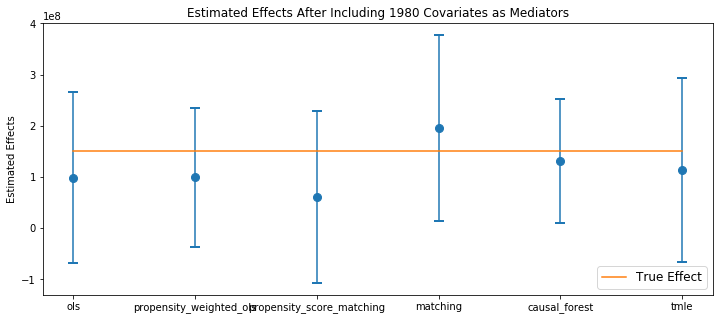

In [14]:
plot_year(1980)

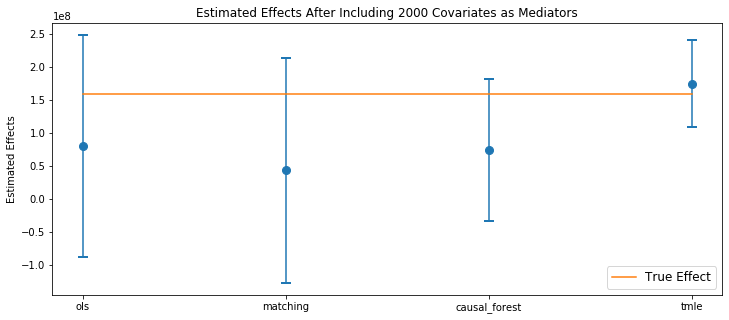

In [15]:
plot_year(2000)

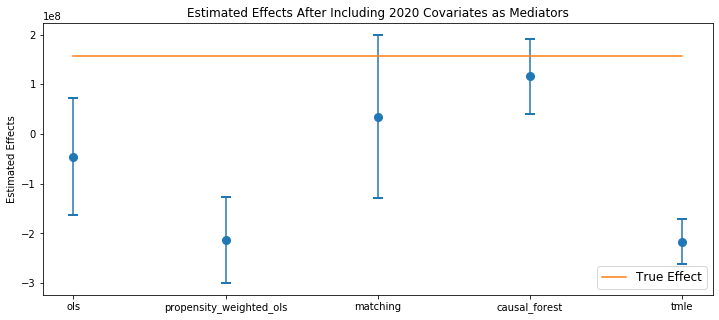

In [16]:
plot_year(2020)